Bachu SaiPreetham

#Question 2

Link: https://www.kaggle.com/uciml/iris [Iris dataset has three classes, remove any one of the classes and use the dataset]

In [1]:
from google.colab import files
uploaded=files.upload()

Saving Iris.csv to Iris.csv


In [3]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# PART A
df = pd.read_csv("Iris.csv")
df.head()

Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

In [4]:
# Independent variable = All col - {Species} = X
# Dependent variable = target = Y

X, Y = df.drop(columns = ["Id", "Species"]), df['Species']
# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Independent Features shape : ",X.shape)

for i in range(len(Y)):
  if Y.iat[i] == "Iris-setosa":
    Y.iat[i] = 0
  if Y.iat[i] == "Iris-versicolor":
    Y.iat[i] = 1
  if Y.iat[i] == "Iris-virginica":
    Y.iat[i] = 2
print("Dependent Feature shape : ",Y.shape)

Independent Features shape :  (150, 4)
Dependent Feature shape :  (150,)


In [5]:
# Split a dataset into 80/20 train/test set
from random import randrange

def train_test_split(x, y, split):
  x_train, y_train = list(),list()
  train_size = split * len(x)
  x_test, y_test = list(x), list(y)
  while len(x_train) < train_size:
    idx = randrange(len(x_test))
    x_train.append(x_test.pop(idx))
    y_train.append(y_test.pop(idx))
  return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,0.8)

print("Independent Training Feature Shape :-",X_train.shape)
print("Independent Testing Feature Shape :-",X_test.shape)
print("Dependent Training Feature Shape :- ",Y_train.shape)
print("Dependent Testing Feature Shape :- ",Y_test.shape)

Independent Training Feature Shape :- (120, 4)
Independent Testing Feature Shape :- (30, 4)
Dependent Training Feature Shape :-  (120,)
Dependent Testing Feature Shape :-  (30,)


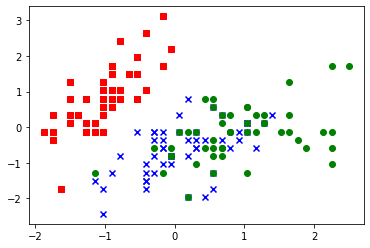

In [7]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

markers = ('s', 'x', 'o')
colors = ('red', 'blue', 'green')
for idx, cl in enumerate(np.unique(Y)):
    plt.scatter(x = X[Y == cl, 0], y = X[Y == cl, 1], marker = markers[idx],color = colors[idx], label = cl)

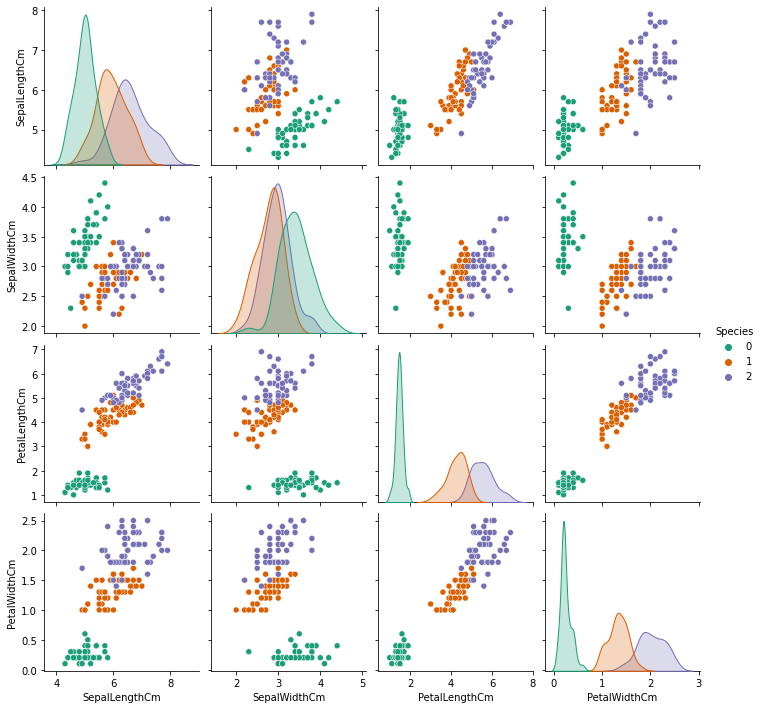

In [8]:
# Setosa is the most separable.
import matplotlib.pyplot as plt
import seaborn as sns

df = df.drop("Id",axis = 1)
sns.pairplot(df, hue='Species',palette='Dark2')

In [9]:
# Objective function
# For optimization
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize
import warnings
warnings.filterwarnings("ignore")

In [10]:
ZERO = 1e-7
def lagrange_dual(alpha, x, y):
    res = 0
    idx_sv = np.where(alpha > ZERO)[0]
    for i in idx_sv:
        for j in idx_sv:
            res = res + alpha[i]*alpha[j] * y[i]*y[j] * np.dot(x[i, :], x[j, :]) 
    res = 0.5*res - sum(alpha)     
    return res

In [11]:
def optimize_alpha(x, y):
    m, n = x.shape
    np.random.seed(1)
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*100
    # Define the constraint
    linear_constraint = LinearConstraint(y, [0], [0])
    # Define the bounds
    bounds_alpha = Bounds(np.zeros(m), np.full(m, 1))

    # Find the optimal value of alpha
    res = minimize(lagrange_dual, alpha_0, args = (x, y), method='slsqp', 
                       hess=BFGS(), constraints=[linear_constraint],
                       bounds=bounds_alpha)
    
    # The optimized value of alpha lies in result.x
    alpha = res.x
    return alpha

In [12]:
def get_w(alpha, x, y):
    m = len(x)
    # Get all support vectors
    w = np.zeros(x.shape[1])
    for i in range(m):
        w = w + alpha[i]*y[i]*x[i, :]        
    return w

def get_w0(alpha, x, y, w):
    C_num = 100-ZERO
    # Indices of support vectors with alpha<C
    idx_sv = np.where((alpha > ZERO)&(alpha < C_num))[0]
    w0 = 0.0
    for s in idx_sv:
        w0 = w0 + y[s] - np.dot(x[s, :], w)
    # Take the average
    l = len(idx_sv)
    if l == 0:
      l = 1
    w0 = w0 / l
    return w0

In [14]:
def prediction(x_test, w, w0):
    # get y(x_test)
    y_pred = np.sum(x_test*w, axis=1) + w0
    y_pred = np.sign(y_pred)
    # Assign a label arbitrarily a +1 if it is zero
    y_pred[y_pred == 0] = 1
    return y_pred

#find accuracy
def Accuracy(actual, predict):
  l = len(actual)
  accuracy = sum(actual == predict)
  return accuracy/l*100

In [15]:
def SVM(x_train, y_train, x_test, y_test):
  #get alpha
  alpha = optimize_alpha(x_train, y_train)
  
  #get theta
  w = get_w(alpha, x_train, y_train)
  w0 = get_w0(alpha, x_train, y_train, w)
  #get predicted value of y
  y_pred = prediction(x_test, w, w0)

  #get Accuracy
  accuracy = Accuracy(y_test, y_pred)
  return accuracy

y_train_unique = set(Y_train)
accuracy = 0.0

for i in y_train_unique:
  y_train_curr = np.where((Y_train == i), 1, -1)
  y_test_curr = np.where((Y_test == i), 1, -1)
  accuracy += SVM(X_train, y_train_curr, X_test, y_test_curr)

accuracy = accuracy/len(y_train_unique)
print("Accuracy :-",accuracy)

KeyboardInterrupt: ignored